In [1]:
import torch

print("PyTorch Version : {}".format(torch.__version__))

PyTorch Version : 2.2.1+cu121


In [2]:
import torchtext

print("Torch Text Version : {}".format(torchtext.__version__))

Torch Text Version : 0.17.1+cpu


In [3]:
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english") ## We'll use tokenizer available from PyTorch

tokenizer("Hello, How are you?")

['hello', ',', 'how', 'are', 'you', '?']

In [4]:
from torchtext.vocab import GloVe

global_vectors = GloVe(name='840B', dim=300)

In [5]:
embeddings = global_vectors.get_vecs_by_tokens(tokenizer("Hello, How are you?"), lower_case_backup=True)

embeddings.shape

torch.Size([6, 300])

In [6]:
!pip install portalocker==2.8.2


In [9]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

max_words = 25
embed_len = 300

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [tokenizer(x) for x in X]
    X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]
    X_tensor = torch.zeros(len(batch), max_words, embed_len)
    for i, tokens in enumerate(X):
        X_tensor[i] = global_vectors.get_vecs_by_tokens(tokens)
    return X_tensor.reshape(len(batch), -1), torch.tensor(Y) - 1 ## Subtracted 1 from labels to bring in range [0,1,2,3] from [1,2,3,4]

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=1024, collate_fn=vectorize_batch)

In [10]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 7500]) torch.Size([1024])


In [11]:
from torch import nn
from torch.nn import functional as F

class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(max_words*embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [12]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i%5==0:
            print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
            CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [13]:
from torch.optim import Adam

epochs = 25
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:17<00:00,  6.59it/s]


Train Loss : 0.160
Valid Loss : 0.507
Valid Acc  : 0.855


100%|██████████| 118/118 [00:17<00:00,  6.61it/s]


Train Loss : 0.073
Valid Loss : 0.596
Valid Acc  : 0.858


100%|██████████| 118/118 [00:17<00:00,  6.83it/s]


Train Loss : 0.016
Valid Loss : 0.851
Valid Acc  : 0.879


100%|██████████| 118/118 [00:17<00:00,  6.84it/s]


Train Loss : 0.003
Valid Loss : 0.923
Valid Acc  : 0.879


100%|██████████| 118/118 [00:17<00:00,  6.85it/s]


Train Loss : 0.002
Valid Loss : 0.993
Valid Acc  : 0.880


In [14]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8798684210526316

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.89      0.90      1900
      Sports       0.94      0.96      0.95      1900
    Business       0.83      0.83      0.83      1900
    Sci/Tech       0.85      0.84      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


Confusion Matrix : 
[[1692   56   87   65]
 [  25 1822   34   19]
 [  95   31 1582  192]
 [  69   30  210 1591]]


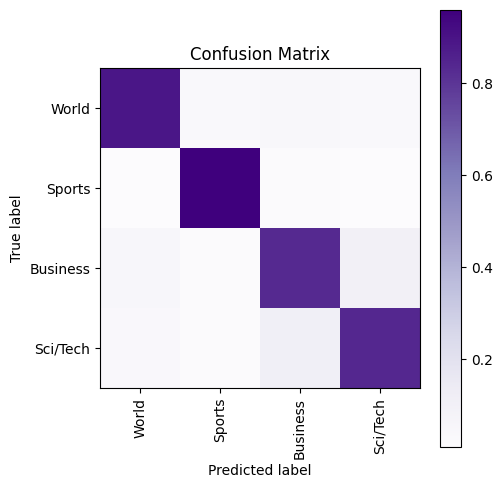

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(Y_actual, Y_preds)

# Normalize confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(target_classes))
plt.xticks(tick_marks, target_classes, rotation=90)
plt.yticks(tick_marks, target_classes)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
